<!-- dom:TITLE: Demo - Working with Functions -->
# Demo - Working with Functions
<!-- dom:AUTHOR: Mikael Mortensen Email:mikaem@math.uio.no at Department of Mathematics, University of Oslo. -->
<!-- Author: -->  
**Mikael Mortensen** (email: `mikaem@math.uio.no`), Department of Mathematics, University of Oslo.

Date: **Aug 7, 2020**

Copyright 2020, Mikael Mortensen. Released under CC Attribution 4.0 license

**Summary.** This is a demonstration of how the Python module [shenfun](https://github.com/spectralDNS/shenfun) can be used to work with
global spectral functions in one and several dimensions.











## Construction

A global spectral function $u(x)$ is represented on a one-dimensional
domain (a line) as

$$
u(x) = \sum_{k=0}^{N-1} \hat{u}_k \psi_k(x)
$$

where $\psi_k(x)$ is the $k$'th basis function and $x$ is a
position inside the domain. $\{\hat{u}_k\}_{k=0}^{N-1}$ are the
expansion coefficient for the series, and often referred to as the
degrees of freedom. There is one degree of freedom per basis function.
We can use any number of basis functions,
and the span of the chosen basis is then a function space. Also part of the
function space is the domain, which is
specified when a function space is created. To create a function space
$T=\text{span}\{T_k\}_{k=0}^{N-1}$ for
the first N Chebyshev polynomials of the first kind on the default domain $[-1, 1]$,
do

In [1]:
from shenfun import *
N = 8
T = FunctionSpace(N, 'Chebyshev', domain=(-1, 1))

The function $u(x)$ can now be created with all N coefficients
equal to zero as

In [2]:
u = Function(T)

When using Chebyshev polynomials the computational domain is always
$[-1, 1]$. However, we can still use a different physical domain,
like

In [3]:
T = FunctionSpace(N, 'Chebyshev', domain=(0, 1))

and under the hood shenfun will then map this domain to the reference
domain through

$$
u(x) = \sum_{k=0}^{N-1} \hat{u}_k \psi_k(2(x-0.5))
$$

## Approximating analytical functions

The `u` function above was created with only zero
valued coefficients, which is the default. Alternatively,
a `Function` may be initialized using a constant
value

In [4]:
T = FunctionSpace(N, 'Chebyshev', domain=(-1, 1))
u = Function(T, val=1)

but that is not very useful. A third method to initialize
a `Function` is to interpolate using an analytical
Sympy function.

In [5]:
import sympy as sp
x = sp.Symbol('x', real=True)
u = Function(T, buffer=4*x**3-3*x)
print(u)

[-6.93889390e-17 -5.47405982e-17 -1.82237827e-18  1.00000000e+00
  1.96261557e-17 -3.33066907e-16  1.49457239e-16 -2.93881977e-16]


Here the analytical Sympy function will first be evaluated
on the entire quadrature mesh of the `T` function space,
and then forward transformed to get the coefficients. This
corresponds to a projection to `T`. The projection is

Find $u_h \in T$, such that

$$
(u_h - u, v)_w = 0 \quad \forall v \in T,
$$

where $v \in \{T_j\}_{j=0}^{N-1}$ is a test function,
$u_h=\sum_{k=0}^{N-1} \hat{u}_k T_k$ is a trial function and the
notation $(\cdot, \cdot)_w$ represents a weighted inner product.
In this projection $u_h$ is the `Function`, $u$ is the sympy function and we use sympy
to exactly evaluate $u$ on all quadrature points
$\{x_j\}_{j=0}^{N-1}$. With quadrature we then have

$$
(u, v)_w = \sum_{j\in\mathcal{I}^N} u(x_j) v(x_j) w_j \forall v \in T,
$$

where $\mathcal{I}^N = (0, 1, \ldots, N-1)$ and $\{w_j\}_{j\in \mathcal{I}^N}$
are the quadrature weights. The left hand side of the projection is

$$
(u_h, v)_w = \sum_{j\in\mathcal{I}^N} u_h(x_j) v(x_j) w_j \forall v \in T.
$$

A linear system of equations arise when inserting for the
basis functions

$$
\left(u, T_i\right)_w = \tilde{u}_i \forall i \in \mathcal{I}^N,
$$

and

$$
\begin{align*}
\left(u_h, T_i \right)_w &= (\sum_{k\in \mathcal{I}^N} \hat{u}_k T_k , T_i)_w \\ 
  &= \sum_{k\in \mathcal{I}^N} \left( T_k, T_i\right)_w \hat{u}_k
\end{align*}
$$

with the mass matrix

$$
a_{ik} = \left( T_k, T_i\right)_w   \forall (i, k) \in \mathcal{I}^N \times \mathcal{I}^N,
$$

we can now solve to get the unknown
expansion coefficients. In matrix notation

$$
\hat{u} = A^{-1} \tilde{u},
$$

where $\hat{u}=\{\hat{u}_i\}_{i\in \mathcal{I}^N}$,
$\tilde{u}=\{\tilde{u}_i\}_{i \in \mathcal{I}^N}$ and
$A=\{a_{ki}\}_{(i,k) \in \mathcal{I}^N \times \mathcal{I}^N}$

## Adaptive function size

The number of basis functions can also be left open during creation
of the function space, through

In [6]:
T = FunctionSpace(0, 'Chebyshev', domain=(-1, 1))

This is useful if you want to approximate a function and
are uncertain how many basis functions that are required.
For example, you may want to approximate the function $\cos(20 x)$.
You can then find the required `Function` using

In [7]:
u = Function(T, buffer=sp.cos(20*x))
print(len(u))

45


We see that $N=45$ is required to resolve this function. This agrees
well with what is reported also by [Chebfun](https://www.chebfun.org/docs/guide/guide01.html).
Note that in this process a new `FunctionSpace` has been
created under the hood. The function space of `u` can be
extracted using

In [8]:
Tu = u.function_space()
print(Tu.N)

45


To further show that shenfun is compatible with Chebfun we can also
approximate the Bessel function

In [9]:
T1 = FunctionSpace(0, 'Chebyshev', domain=(0, 100))
u = Function(T1, buffer=sp.besselj(0, x))
print(len(u))

83


which gives 83 basis functions, in close agreement with Chebfun (89).
The difference lies only in the cut-off criteria. We cut frequencies
with a relative tolerance of 1e-12 by default, but if we make this criteria
a little bit stronger, then we will also arrive at a slightly higher number:

In [10]:
u = Function(T1, buffer=sp.besselj(0, x), reltol=1e-14)
print(len(u))

87


Plotting the function on its quadrature points looks
a bit ragged, though:

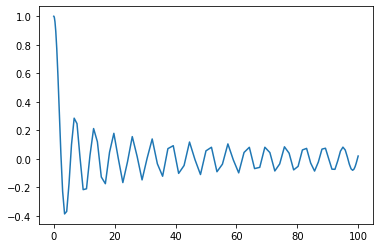

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
Tu = u.function_space()
plt.plot(Tu.mesh(), u.backward())

To improve the quality of this plot we can instead evaluate the
function on more points

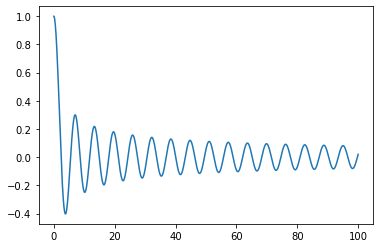

In [12]:
xj = np.linspace(0, 100, 1000)
plt.plot(xj, u(xj))

Alternatively, we can refine the function, which simply
pads zeros to $\hat{u}$

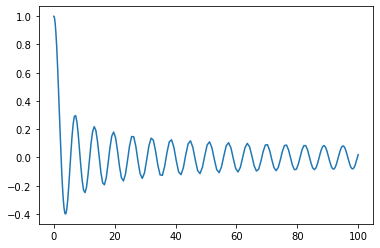

In [13]:
up = u.refine(200)
Tp = up.function_space()
plt.plot(Tp.mesh(), up.backward())

The padded expansion coefficients are now given as

In [14]:
print(up)

[ 6.43655435e-02 -1.37262942e-01  1.26593632e-01 -1.31630372e-01
  1.19810309e-01 -1.19499576e-01  1.07387826e-01 -9.95196201e-02
  8.81197795e-02 -7.07299943e-02  6.13974837e-02 -3.40222966e-02
  2.84578300e-02  6.05886310e-03 -6.23468323e-03  4.01956708e-02
 -3.44202241e-02  5.58353154e-02 -4.58848577e-02  4.33923041e-02
 -3.39778387e-02  6.26445963e-03 -3.37831264e-03 -3.27304442e-02
  2.63630973e-02 -4.12313235e-02  3.07429560e-02 -7.73458857e-03
  4.10441868e-03  3.29922472e-02 -2.47812478e-02  2.71654360e-02
 -1.81421444e-02 -2.02112290e-02  1.53660102e-02 -3.02943723e-02
  1.97324599e-02  1.94051084e-02 -1.41460820e-02  2.47321146e-02
 -1.49668436e-02 -3.02763148e-02  1.98156190e-02 -2.08517347e-03
 -6.91643640e-05  3.13799203e-02 -1.81924272e-02 -3.77110141e-02
  2.23051599e-02  2.82766986e-02 -1.67226896e-02 -1.59965877e-02
  9.40673776e-03  7.34392211e-03 -4.28398348e-03 -2.84497604e-03
  1.64428109e-03  9.53197714e-04 -5.45450869e-04 -2.80998822e-04
  1.59136941e-04  7.38240

## More features

Since we have used a regular Chebyshev basis above, there
are many more features that could be explored simply by going through
[Numpy's Chebyshev module](https://numpy.org/doc/stable/reference/routines.polynomials.chebyshev.html).
For example, we can create a Chebyshev series like

In [15]:
import numpy.polynomial.chebyshev as cheb
c = cheb.Chebyshev(u, domain=(0, 100))

The Chebyshev series in Numpy has a wide range of possibilities,
see [here](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.chebyshev.Chebyshev.html#numpy.polynomial.chebyshev.Chebyshev).
However, we may also work directly with the Chebyshev
coefficients already in `u`. To find the roots of the
polynomial that approximates the Bessel function on
domain $[0, 100]$, we can do

In [16]:
z = Tu.map_true_domain(cheb.chebroots(u))

Note that the roots are found on the reference domain $[-1, 1]$
and as such we need to move the result to the physical domain using
`map_true_domain`. The resulting roots `z` are both real and imaginary,
so to extract the real roots we need to filter a little bit

In [17]:
z2 = z[np.where((z.imag == 0)*(z.real > 0)*(z.real < 100))].real
print(z2[:5])

[ 2.40482556  5.52007811  8.65372791 11.79153444 14.93091771]


Here `np.where` returns the indices where the condition is true. The condition
is that the imaginary part is zero, whereas the real part is within the
true domain $[0, 100]$.

**Notice.**

Using directly `cheb.chebroots(c)` does not seem to work (even though the
series has been generated with the non-standard domain) because
Numpy only looks for roots in the reference domain $[-1, 1]$.



We could also use a function space with boundary conditions built
in, like

In [18]:
Td = FunctionSpace(0, 'C', bc=(sp.besselj(0, 0), sp.besselj(0, 100)), domain=(0, 100))
ud = Function(Td, buffer=sp.besselj(0, x))
print(len(ud))

82


As we can see this also leads to a function space of dimension 83,
which is very similar to the orthogonal space.

The major advantages of working with a space with boundary conditions
built in only comes to life when solving differential equations. As
long as we are only interested in approximating functions, we may just
as well stick to the orthogonal spaces. This goes for Legendre as
well as Chebyshev.

## Multidimensional functions

Multidimensional tensor product spaces are created
by taking the tensor products of one-dimensional function spaces.
For example

In [19]:
C0 = FunctionSpace(20, 'C')
C1 = FunctionSpace(20, 'C')
T = TensorProductSpace(comm, (C0, C1))
u = Function(T)

Here $\text{T} = \text{C0} \otimes \text{C1}$, the basis function is
$T_i(x) T_j(y)$ and the Function `u` is

$$
u(x, y) = \sum_{i=0}^{7} \sum_{j=0}^7 \hat{u}_{ij} T_i(x) T_j(y).
$$

The multidimensional Functions work more or less exactly like for the
1D case. We can here interpolate 2D Sympy functions

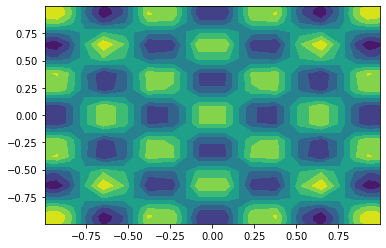

In [20]:
y = sp.Symbol('y', real=True)
u = Function(T, buffer=sp.cos(10*x)*sp.cos(10*y))
X = T.local_mesh(True)
plt.contourf(X[0], X[1], u.backward())

Like for 1D the coefficients are computed through projection,
where the exact function is evaluated on all quadrature points
in the mesh.

The Cartesian mesh represents the quadrature points of the
two function spaces, and can be visualized as follows

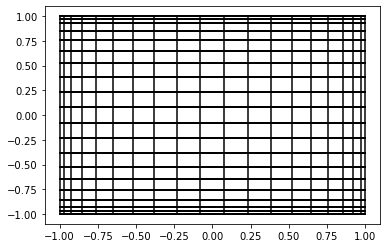

In [21]:
X = T.mesh()
for xj in X[0]:
    for yj in X[1]:
        plt.plot((xj, xj), (X[1][0, 0], X[1][0, -1]), 'k')
        plt.plot((X[0][0], X[0][-1]), (yj, yj), 'k')

We may alternatively plot on a uniform mesh

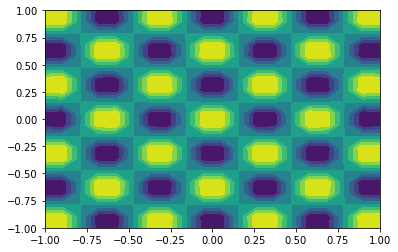

In [22]:
X = T.local_mesh(broadcast=True, uniform=True)
plt.contourf(X[0], X[1], u.backward(kind='uniform'))

## Curvilinear coordinates

With shenfun it is possible to use curvilinear coordinates,
and not necessarily with orthogonal basis vectors. With
curvilinear coordinates the computational coordinates are
always straight lines, rectangles and cubes. But the physical
coordinates can be very complex.

Consider the unit disc with polar coordinates. Here
the position vector $\mathbf{r}$ is given by

$$
\mathbf{r} = r\cos \theta \mathbf{i} + r\sin \theta \mathbf{j}
$$

The physical domain is $\Omega = \{(x, y): x^2 + y^2 < 1\}$,
whereas the computational domain is the Cartesian product
$D = \{(r, \theta) \in [0, 1] \times [0, 2 \pi]\}$.

We create this domain in shenfun through

In [23]:
r, theta = psi = sp.symbols('x,y', real=True, positive=True)
rv = (r*sp.cos(theta), r*sp.sin(theta))
B0 = FunctionSpace(20, 'C', domain=(0, 1))
F0 = FunctionSpace(20, 'F')
T = TensorProductSpace(comm, (B0, F0), coordinates=(psi, rv))

Note that we are using a Fourier space for the azimuthal
direction, since the solution here needs to be periodic.
We can now create functions on the space using an
analytical function in computational coordinates

In [24]:
u = Function(T, buffer=(1-r)*r*sp.sin(sp.cos(theta)))

However, when this is plotted it may not be what you expect

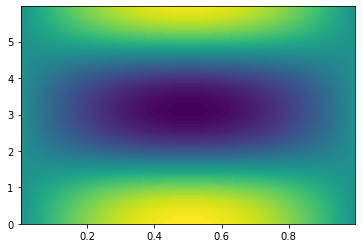

In [25]:
X = T.local_mesh(True)
plt.contourf(X[0], X[1], u.backward(), 100)

We see that the function has been plotted in computational coordinates,
and not on the disc, as you probably expected. To plot on
the disc we need the physical mesh, and not the computational

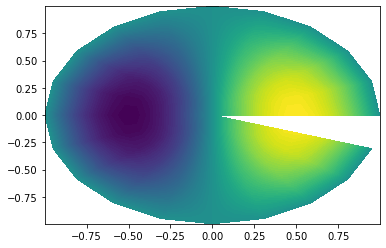

In [26]:
X = T.local_curvilinear_mesh()
plt.contourf(X[0], X[1], u.backward(), 100)

**Notice.**

The periodic plot does not wrap all around the circle. This is
not wrong, we have simply not used the same point twice, but it
does not look very good. To overcome this problem we can wrap the
grid all the way around and re-plot.

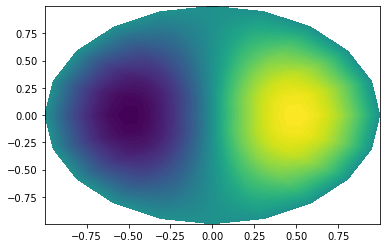

In [27]:
xj, yj = X
xp = np.hstack([xj, xj[:, 0][:, None]])
yp = np.hstack([yj, yj[:, 0][:, None]])
up = u.backward()
up = np.hstack([up, up[:, 0][:, None]])
plt.contourf(xp, yp, up, 100)

## Adaptive functions in multiple dimensions

If you want to find a good resolution for a function in multiple
dimensions, the procedure is exactly like in 1D. First create function
spaces with 0 quadrature points, and then call `Function`

In [28]:
B0 = FunctionSpace(0, 'C', domain=(0, 1))
F0 = FunctionSpace(0, 'F')
T = TensorProductSpace(comm, (B0, F0), coordinates=(psi, rv))
u = Function(T, buffer=((1-r)*r)**2*sp.sin(sp.cos(theta)))
print(u.shape)

(5, 12)


The algorithm used to find the approximation in multiple dimensions
simply treat the problem one direction at the time. So in this case
we would first find a space in the first direction by using
`fun ~ ((1-r)*r)**2`, and then along the second using
`fun ~ sp.sin(sp.cos(theta))`.


<!-- ======= Bibliography ======= -->